<a href="https://colab.research.google.com/github/Larkuo/FindMyGlasses/blob/main/model_training/notebooks/FindMyGlasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **FIND MY GLASSES**
---
---
This is the training notebook for the mobile app **Find My Glasses**

The following list will keep track of the notebook versions with dates

*   v1: 14/02/2023 -> --/--/2023
*   v2: --/--/---- -> --/--/----



### **1 - Getting & Seeing the Data**

In [1]:
# Mount Google Drive because the images & label files are there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pwd

'/content'

In [3]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6220 (delta 5), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6220/6220), 13.48 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (4206/4206), done.


In [4]:
%cd keras-retinanet/
!pip3 install .

/content/keras-retinanet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/keras-retinanet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp39-cp39-linux_x86_64.whl size=180747 sha256=d39e68f4bddc0fe5865534c3e615835f0588cb8752bba4a319273d9891037fa2
  Stored in directory: /root/.cache/pip/wheels/3f/be/fa/528d5f2773281e6dd7795aa3039aea5a871e02ab5491117ad7
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=07f24d6422cbe66926eccca8872fa29eca87dc5ebf6161d64d3a6bfa568f79b7
  Stored in directory: /root/.cache/pip/wheels/53/ed/ef/144804f160c278c80d6429c97ed126b61276721894ce64cccc
Successfully built keras-retinanet keras-resnet


In [5]:
%cd ..
%pwd

/content


'/content'

In [6]:
import os
import natsort
import numpy as np
import pandas as pd
from PIL import Image
from os.path import isfile
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color

In [7]:
train_path='/content/drive/My Drive/TFVision/FindMyGlasses/data/data_v1/data_jpeg/train'
validate_path='/content/drive/My Drive/TFVision/FindMyGlasses/data/data_v1/data_jpeg/validate'

data=pd.DataFrame(columns=['fileName','xmin','ymin','xmax','ymax','class'])

In [8]:
import random

# num = random.randrange(106, 306)
num = 291
base_path = train_path + '/img-' + str(num)

img_path = base_path + '.jpeg'
ann_path = base_path + '.xml'

img_path, ann_path

('/content/drive/My Drive/TFVision/FindMyGlasses/data/data_v1/data_jpeg/train/img-291.jpeg',
 '/content/drive/My Drive/TFVision/FindMyGlasses/data/data_v1/data_jpeg/train/img-291.xml')

In [9]:
if isfile(img_path) and isfile(ann_path):
  tree = ET.parse(ann_path)
  root = tree.getroot()
  for obj in root.iter('object'):
    class_name = obj.find('name').text
    bnd_box = obj.find('bndbox')
    xmin = bnd_box.find('xmin').text
    ymin = bnd_box.find('ymin').text
    xmax = bnd_box.find('xmax').text
    ymax = bnd_box.find('ymax').text
    # Append rows in Empty Dataframe by adding dictionaries
    xml_dict = {'fileName': img_path, 'xmin': xmin, 'ymin':ymin,'xmax':xmax,'ymax':ymax,'class':class_name}
    data = data.append(xml_dict, ignore_index=True)

In [10]:
data

,fileName,xmin,ymin,xmax,ymax,class
0,/content/drive/My Drive/TFVision/FindMyGlasses...,3,19,156,187,glasses
1,/content/drive/My Drive/TFVision/FindMyGlasses...,219,29,367,175,glasses
2,/content/drive/My Drive/TFVision/FindMyGlasses...,17,228,209,366,glasses
3,/content/drive/My Drive/TFVision/FindMyGlasses...,207,212,363,354,glasses


bnd_box: 0 ['3', '19', '156', '187']
bnd_box: 1 ['219', '29', '367', '175']
bnd_box: 2 ['17', '228', '209', '366']
bnd_box: 3 ['207', '212', '363', '354']


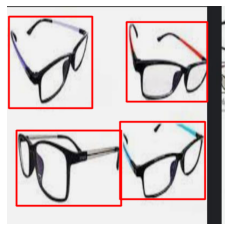

In [11]:
im = np.array(Image.open(img_path))

# if there's a PNG it will have alpha channel
im = im[:,:,:3]

for idx, row in data.iterrows():
  box = [row['xmin'], row['ymin'], row['xmax'], row['ymax'],]
  print(f"bnd_box: {str(idx)}", box)
  draw_box(im, box, color=(255, 0, 0))


plt.axis('off')
plt.imshow(im)
plt.show()           

### **2 - Organizing the Data for training**

In [12]:
!pip3 install numba
!pip3 install -q tflite-model-maker
!pip3 install -q tflite-support
!pip3 install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.

In [13]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [14]:
train_path='/content/drive/My Drive/TFVision/FindMyGlasses/data/data_v1/data_jpeg/train'
validate_path='/content/drive/My Drive/TFVision/FindMyGlasses/data/data_v1/data_jpeg/validate'

train_data = object_detector.DataLoader.from_pascal_voc(
    train_path, train_path, ['glasses'])

val_data = object_detector.DataLoader.from_pascal_voc(
    validate_path, validate_path, ['glasses'])

len(train_data), len(val_data)

(200, 52)

Select a model architecture

-----
EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

The performance of each EfficientDet-Lite model compared to others is shown in the table below.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |
    
* Size of the integer quantized models.
* Latency measured on Raspberry Pi 4 using 4 threads on CPU.
* Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.

In [20]:
spec = model_spec.get('efficientdet_lite0')

model = object_detector.create(train_data, model_spec=spec, batch_size=10, train_whole_model=True, epochs=500, validation_data=val_data)

Epoch 1/500
20/20 [==============================] - 43s 627ms/step - det_loss: 1.6211 - cls_loss: 1.0394 - box_loss: 0.0116 - reg_l2_loss: 0.0630 - loss: 1.6841 - learning_rate: 0.0102 - gradient_norm: 2.4422 - val_det_loss: 1.1934 - val_cls_loss: 0.6965 - val_box_loss: 0.0099 - val_reg_l2_loss: 0.0630 - val_loss: 1.2564
Epoch 2/500
20/20 [==============================] - 7s 362ms/step - det_loss: 1.0689 - cls_loss: 0.6192 - box_loss: 0.0090 - reg_l2_loss: 0.0630 - loss: 1.1319 - learning_rate: 0.0125 - gradient_norm: 2.7680 - val_det_loss: 1.0898 - val_cls_loss: 0.4663 - val_box_loss: 0.0125 - val_reg_l2_loss: 0.0630 - val_loss: 1.1528
Epoch 3/500
20/20 [==============================] - 9s 446ms/step - det_loss: 0.7453 - cls_loss: 0.3960 - box_loss: 0.0070 - reg_l2_loss: 0.0631 - loss: 0.8084 - learning_rate: 0.0125 - gradient_norm: 3.3630 - val_det_loss: 1.1397 - val_cls_loss: 0.8016 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0631 - val_loss: 1.2028
Epoch 4/500
20/20 [===========

In [21]:
model.evaluate(val_data)

1/1 [==============================] - 8s 8s/step



{'AP': 0.83622813,
 'AP50': 0.9906821,
 'AP75': 0.9358363,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.84279233,
 'ARmax1': 0.7241936,
 'ARmax10': 0.89032257,
 'ARmax100': 0.8967742,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.8967742,
 'AP_/glasses': 0.83622813}

In [22]:
save_path = '/content/drive/My Drive/TFVision/FindMyGlasses/models/model_final_101.tflite'
# batch = 10; epochs = 500 architecture = efficientdet_lite0

In [23]:
model.export(export_dir='.', tflite_filename=save_path)

In [24]:
model.evaluate_tflite(save_path, val_data)

52/52 [==============================] - 153s 3s/step



{'AP': 0.8285541,
 'AP50': 0.9901338,
 'AP75': 0.9348445,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.83349085,
 'ARmax1': 0.7241936,
 'ARmax10': 0.86290324,
 'ARmax100': 0.86290324,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.86290324,
 'AP_/glasses': 0.8285541}